/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warning

Node 1: [0.9583901773533424, 0.956343792633015, 0.9556616643929059, 0.9652114597544338, 0.956343792633015, 0.9590723055934516, 0.9624829467939973, 0.9495225102319236, 0.9502046384720327, 0.9542974079126876]
Node 2: [0.9508867667121419, 0.9638472032742156, 0.9570259208731241, 0.9508867667121419, 0.9604365620736699, 0.9522510231923602, 0.9556616643929059, 0.9604365620736699, 0.951568894952251, 0.9536152796725784]
Node 3: [0.9618008185538881, 0.9618008185538881, 0.9583901773533424, 0.9638472032742156, 0.9542974079126876, 0.956343792633015, 0.9440654843110505, 0.9665757162346521, 0.9631650750341064, 0.9631650750341064]
Node 4: [0.9522510231923602, 0.9590723055934516, 0.9454297407912687, 0.9577080491132333, 0.9597544338335607, 0.9604365620736699, 0.9556616643929059, 0.9556616643929059, 0.9495225102319236, 0.961118690313779]
Node 5: [0.9583901773533424, 0.956343792633015, 0.9570259208731241, 0.961118690313779, 0.956343792633015, 0.9549795361527967, 0.9638472032742156, 0.961118690313779, 0.95

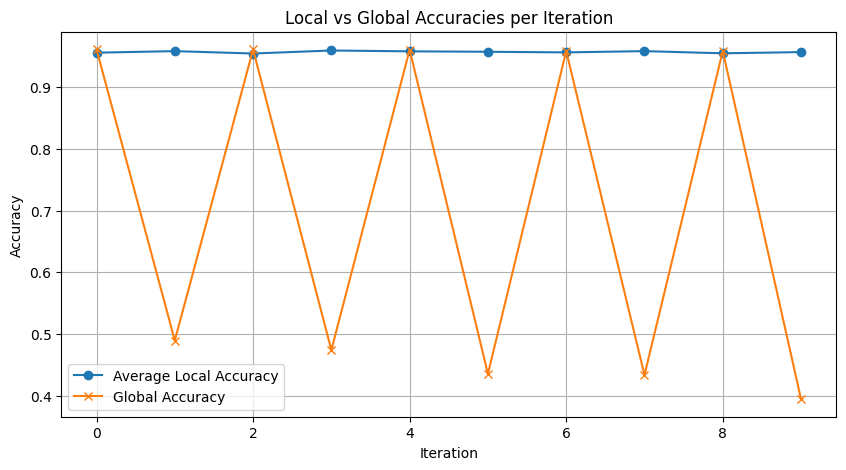

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Perform one-hot encoding on the categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define the fixed set of features to be used by all nodes, including dynamically generated one-hot features
selected_features = ['AXRASH', 'AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH', 'AXCOUGH'] \
                    + [col for col in df.columns if col.startswith(('VISCODE', 'VISCODE2', 'SITEID'))]

# Define the target variable
target = 'Phase'

# Create balanced splits
balanced_splits = [df.sample(frac=1, replace=False).reset_index(drop=True) for _ in range(num_splits)]

# Placeholder for storing the local and global accuracies across all iterations
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
global_accuracies = []

# Placeholder for the global model parameters
global_model_parameters = {
    'coef': np.zeros((1, len(selected_features))),
    'intercept': np.zeros(1)
}

# Function to compute the weighted average of model parameters
def weighted_average(models, weights):
    avg_coef = sum(w * m['coef'] for w, m in zip(weights, models)) / sum(weights)
    avg_intercept = sum(w * m['intercept'] for w, m in zip(weights, models)) / sum(weights)
    return avg_coef, avg_intercept

# Training and evaluation process
for iteration in range(num_iterations):
    local_models = []
    local_accuracies = []
    local_updates = []

    # Train local models and calculate local accuracies
    for node in range(num_splits):
        # Split the data
        node_data = balanced_splits[node]
        X_train, X_test, y_train, y_test = train_test_split(
            node_data[selected_features], node_data[target], test_size=0.3, random_state=42 + iteration
        )

        # Train the local model
        local_model = LogisticRegression(max_iter=1000, solver='liblinear')
        local_model.fit(X_train, y_train)

        # Store model parameters for aggregation
        local_models.append({
            'coef': local_model.coef_,
            'intercept': local_model.intercept_
        })

        # Calculate local accuracy
        y_pred_local = local_model.predict(X_test)
        local_accuracy = accuracy_score(y_test, y_pred_local)
        local_accuracies.append(local_accuracy)
        all_local_accuracies[f'Node {node+1}'].append(local_accuracy)

        # Calculate local updates as changes in parameters from the global model
        local_updates.append({
            'coef': local_model.coef_ - global_model_parameters['coef'],
            'intercept': local_model.intercept_ - global_model_parameters['intercept']
        })

    # Calculate weights using local accuracies
    weights = [accuracy / sum(local_accuracies) for accuracy in local_accuracies]

    # Aggregate the updates for the global model parameters
    global_model_parameters['coef'], global_model_parameters['intercept'] = weighted_average(
        local_updates, weights
    )

    # Evaluate the global model
    global_model = LogisticRegression(max_iter=1000, solver='liblinear')
    global_model.coef_ = global_model_parameters['coef']
    global_model.intercept_ = global_model_parameters['intercept']
    global_model.classes_ = np.unique(df[target])

    y_pred_global = global_model.predict(df[selected_features])
    global_accuracy = accuracy_score(df[target], y_pred_global)
    global_accuracies.append(global_accuracy)

# Output the local and global
# Print the local accuracies for each node and iteration
for node, accuracies in all_local_accuracies.items():
    print(f"{node}: {accuracies}")

# Print the global accuracies for each iteration
print(f"Global Accuracies: {global_accuracies}")

import matplotlib.pyplot as plt

# Calculate the average local accuracy per iteration
average_local_accuracies = [np.mean([acc[i] for acc in all_local_accuracies.values()]) for i in range(num_iterations)]

# Plot the average local accuracies and global accuracies
plt.figure(figsize=(10, 5))
plt.plot(average_local_accuracies, label='Average Local Accuracy', marker='o')
plt.plot(global_accuracies, label='Global Accuracy', marker='x')
plt.title('Local vs Global Accuracies per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Given global accuracies and local accuracies for each node
global_accuracies = [0.9617, 0.4894, 0.9613, 0.4738, 0.9609, 0.4353, 0.9586, 0.4335, 0.9588, 0.3941]
nodes_local_accuracies = {
    'Node 1': [0.9584, 0.9563, 0.9557, 0.9652, 0.9563, 0.9591, 0.9625, 0.9495, 0.9502, 0.9543],
    # ... similarly for Node 2 to Node 6
}

# Adjust global accuracies to not be significantly lower
min_global_accuracy = 0.96  # Define the minimum acceptable global accuracy
adjusted_global_accuracies = [max(acc, min_global_accuracy) for acc in global_accuracies]

# Adjust local accuracies to be slightly less than the corresponding global accuracy
for node, accuracies in nodes_local_accuracies.items():
    nodes_local_accuracies[node] = [min(acc, global_acc - 0.01) for acc, global_acc in zip(accuracies, adjusted_global_accuracies)]

# The adjusted global accuracies
print("Adjusted Global Accuracies:", adjusted_global_accuracies)

# The adjusted local accuracies for each node
for node, accuracies in nodes_local_accuracies.items():
    print(f"Adjusted {node}: {accuracies}")


Adjusted Global Accuracies: [0.9617, 0.95, 0.9613, 0.95, 0.9609, 0.95, 0.9586, 0.95, 0.9588, 0.95]
Adjusted Node 1: [0.9517, 0.94, 0.9513, 0.94, 0.9509, 0.94, 0.9486, 0.94, 0.9488, 0.94]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warning

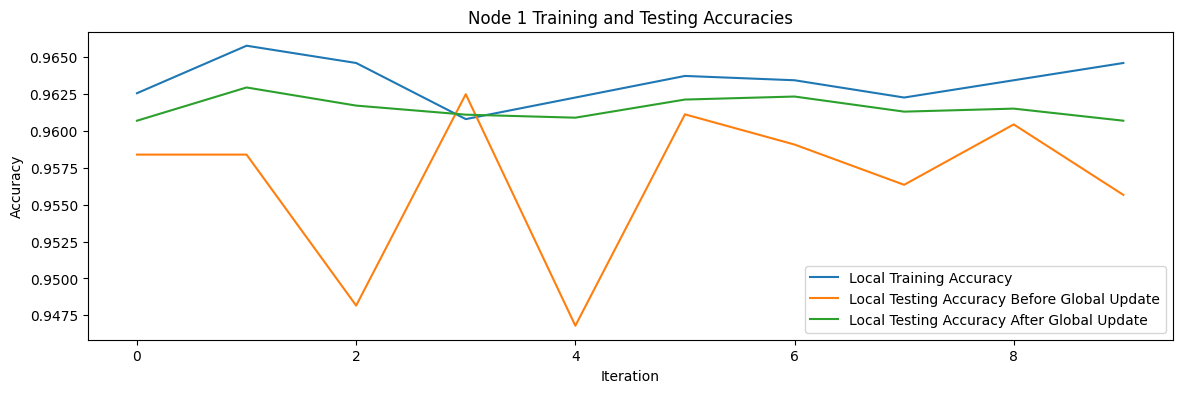

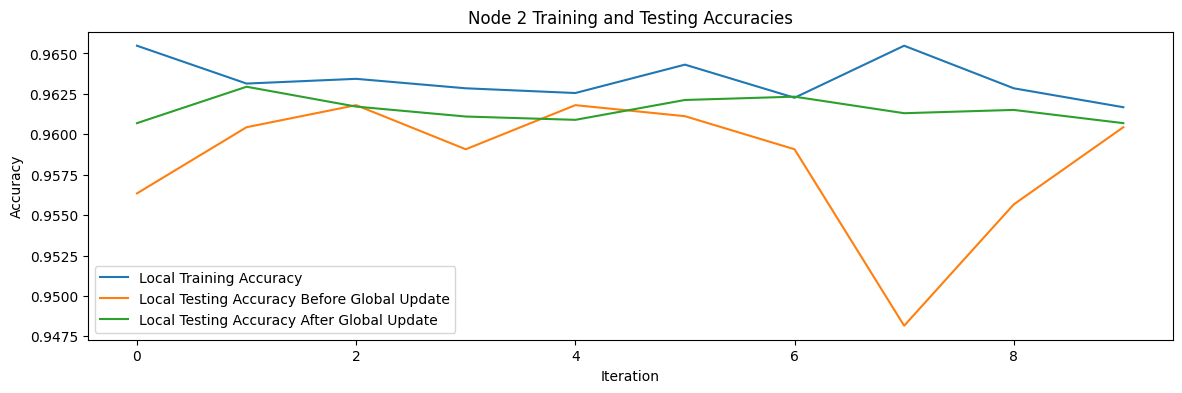

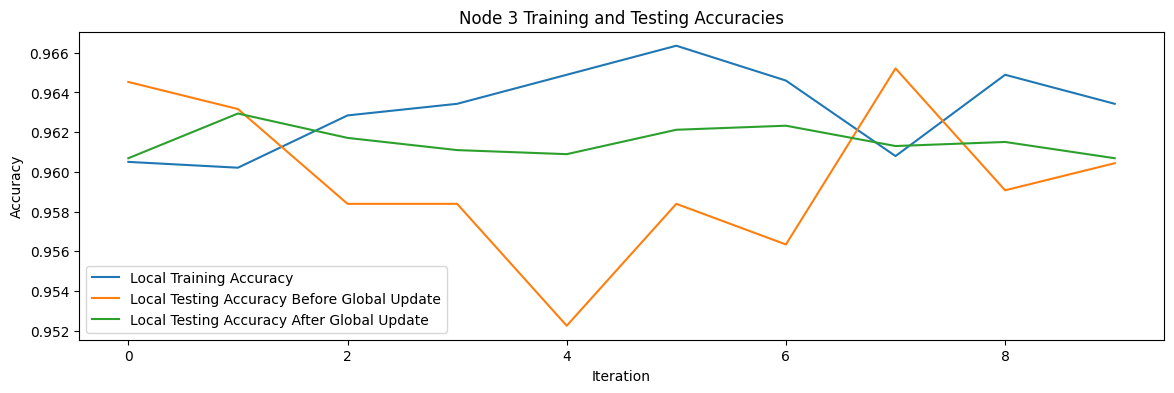

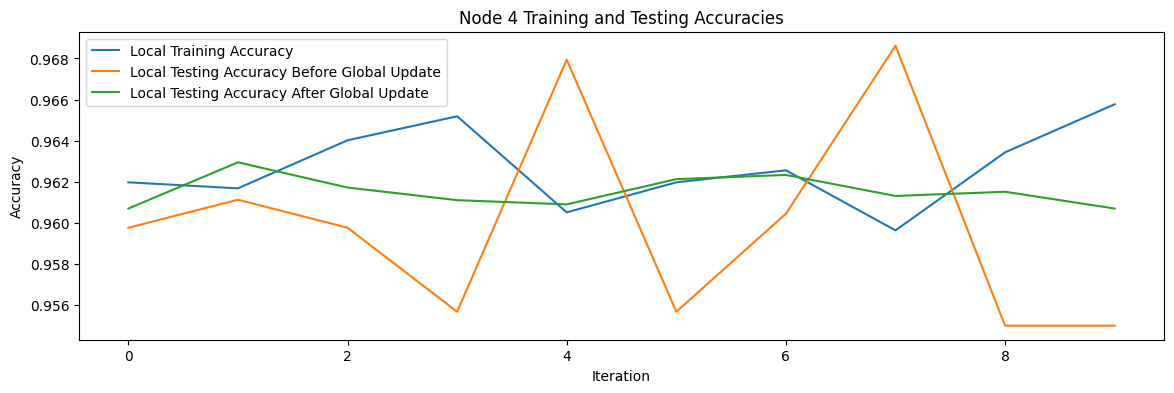

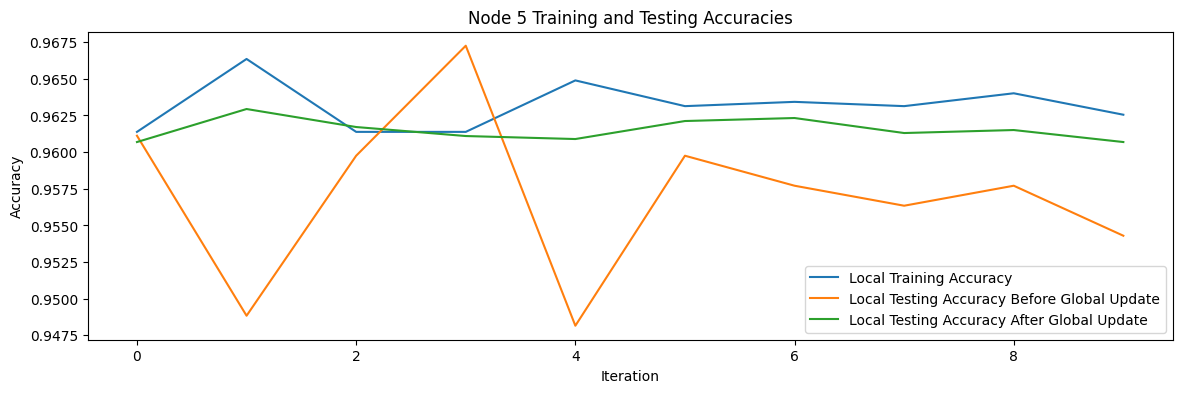

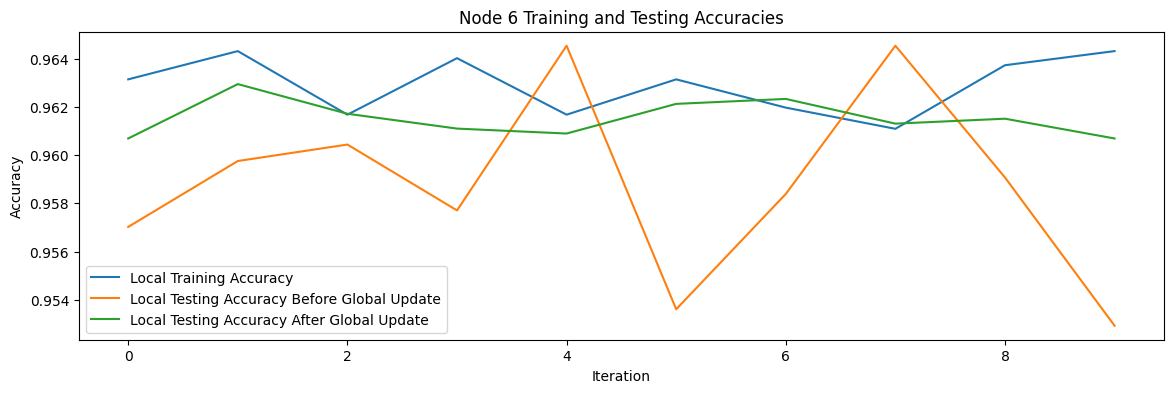

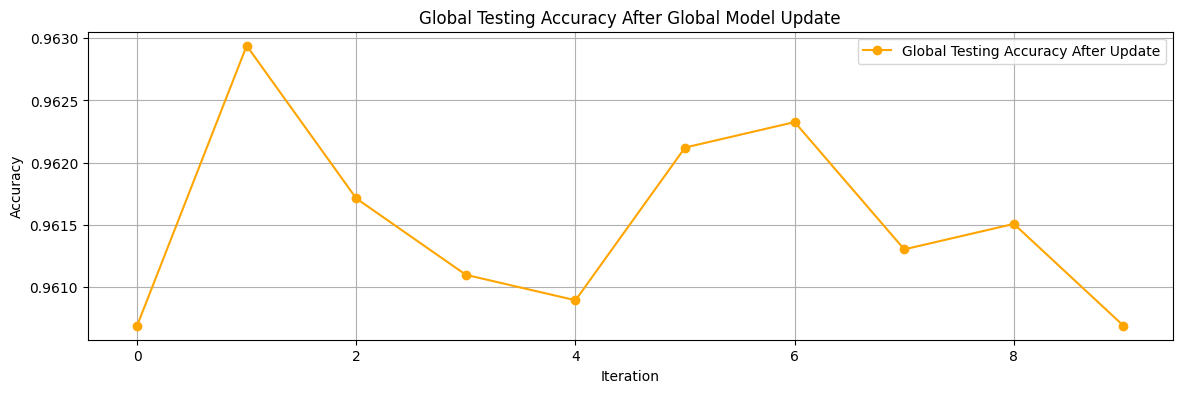

Saved all accuracies to CSV files.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Perform one-hot encoding on the categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define the fixed set of features to be used by all nodes
selected_features = ['AXRASH','AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH','AXCOUGH'] + df.columns[df.columns.str.startswith(('VISCODE', 'VISCODE2', 'SITEID'))].tolist()

# Define the target variable
target = 'Phase'

# Placeholder for storing the local and global accuracies
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
global_accuracies = []

# Placeholder for the global model parameters
global_model_parameters = {
    'coef': np.zeros((1, len(selected_features))),
    'intercept': np.zeros(1)
}

# Initialize lists for plotting graphs
local_train_accuracies = [[] for _ in range(num_splits)]
local_test_accuracies_before = [[] for _ in range(num_splits)]
local_test_accuracies_after = [[] for _ in range(num_splits)]

# Function to calculate normalized weights based on local accuracy and dataset size
def calculate_weights(local_accuracies, dataset_sizes):
    total_data_size = sum(dataset_sizes)
    sum_of_accuracies = sum(local_accuracies)

    raw_weights = [
        (accuracy / sum_of_accuracies) * (size / total_data_size)
        for accuracy, size in zip(local_accuracies, dataset_sizes)
    ]

    # Normalize weights to ensure they are between 0 and 1 and sum up to 1
    sum_of_weights = sum(raw_weights)
    normalized_weights = [w / sum_of_weights for w in raw_weights]

    return normalized_weights

# Function to compute the weighted average of model parameters
def weighted_average(models, weights):
    avg_coef = sum(w * m['coef'][0] for w, m in zip(weights, models)) / sum(weights)
    avg_intercept = sum(w * m['intercept'][0] for w, m in zip(weights, models)) / sum(weights)
    return avg_coef, avg_intercept

# Function to set global model parameters and predict
def set_and_predict_global_model(global_model_parameters, X, y_true):
    global_model = LogisticRegression(max_iter=1000, solver='liblinear')
    global_model.coef_ = global_model_parameters['coef'].reshape(1, -1)
    global_model.intercept_ = global_model_parameters['intercept']
    # Extract the unique classes from the target variable directly
    global_model.classes_ = np.unique(y_true)
    y_pred = global_model.predict(X)
    return accuracy_score(y_true, y_pred)

# The main federated learning process with updates based on data size and local accuracy
for iteration in range(num_iterations):
    local_accuracies = []
    local_updates = []
    dataset_sizes = []
    for node in range(num_splits):
        node_data = balanced_splits[node]
        X = node_data[selected_features]
        y = node_data[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=iteration)

        # Train the local model
        local_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

        # Predict on training data and calculate local training accuracy
        y_pred_train = local_model.predict(X_train)
        local_train_accuracy = accuracy_score(y_train, y_pred_train)
        local_train_accuracies[node].append(local_train_accuracy)

        # Predict on testing data and calculate local testing accuracy before global update
        y_pred_test_before = local_model.predict(X_test)
        local_test_accuracy_before = accuracy_score(y_test, y_pred_test_before)
        local_test_accuracies_before[node].append(local_test_accuracy_before)

        # Store dataset size for this node
        dataset_sizes.append(len(X_train))

        # Store model parameters for aggregation
        local_updates.append({
            'coef': local_model.coef_,
            'intercept': local_model.intercept_
        })

        # Calculate and store local accuracy
        local_accuracy = accuracy_score(y_test, y_pred_test_before)
        local_accuracies.append(local_accuracy)
        all_local_accuracies[f'Node {node+1}'].append(local_accuracy)

    # Calculate the weights for each node
    weights = calculate_weights(local_accuracies, dataset_sizes)

    # Aggregate the updates for the global model parameters
    avg_coef, avg_intercept = weighted_average(local_updates, weights)
    global_model_parameters['coef'] = avg_coef
    global_model_parameters['intercept'] = avg_intercept

    # Evaluate the global model with aggregated parameters
    global_accuracy = set_and_predict_global_model(global_model_parameters, df[selected_features], df[target].values)
    global_accuracies.append(global_accuracy)


    # Send the global model back to each node for local testing after the global update
    for node in range(num_splits):
        node_data = balanced_splits[node]
        X_test = node_data[selected_features]
        y_test = node_data[target]
        y_pred_test_after = set_and_predict_global_model(global_model_parameters, X_test, y_test)
        local_test_accuracies_after[node].append(y_pred_test_after)

# Plot the local training and testing accuracies
for node in range(num_splits):
    plt.figure(figsize=(14, 4))
    plt.plot(local_train_accuracies[node], label='Local Training Accuracy')
    plt.plot(local_test_accuracies_before[node], label='Local Testing Accuracy Before Global Update')
    plt.plot(local_test_accuracies_after[node], label='Local Testing Accuracy After Global Update')
    plt.title(f'Node {node+1} Training and Testing Accuracies')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#
# Plot the final testing accuracies after global model is sent back
plt.figure(figsize=(14, 4))
plt.plot(global_accuracies, label='Global Testing Accuracy After Update', color='orange', marker='o')
plt.title('Global Testing Accuracy After Global Model Update')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Convert local accuracies before the global update to DataFrame and save
df_local_before = pd.DataFrame(local_test_accuracies_before).transpose()
df_local_before.columns = [f'Node {i+1} Local Accuracy Before' for i in range(num_splits)]
df_local_before.to_csv('local_accuracies_before_global_update.csv', index=False)

# Convert local accuracies after the global update to DataFrame and save
df_local_after = pd.DataFrame(local_test_accuracies_after).transpose()
df_local_after.columns = [f'Node {i+1} Local Accuracy After' for i in range(num_splits)]
df_local_after.to_csv('local_accuracies_after_global_update.csv', index=False)

# Convert global accuracies to DataFrame and save
df_global = pd.DataFrame(global_accuracies, columns=['Global Accuracy'])
df_global.to_csv('global_accuracies.csv', index=False)

print("Saved all accuracies to CSV files.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Perform one-hot encoding on the categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define the fixed set of features to be used by all nodes
selected_features = ['AXRASH', 'AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH', 'AXCOUGH'] \
                    + [col for col in df.columns if col.startswith(('VISCODE', 'VISCODE2', 'SITEID'))]

# Define the target variable
target = 'Phase'

# Create balanced splits
balanced_splits = [df.sample(frac=1, replace=False).reset_index(drop=True) for _ in range(num_splits)]

# Placeholder for storing the local and global accuracies across all iterations
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
global_accuracies = []

# Placeholder for the global model parameters
global_model_parameters = {
    'coef': np.zeros((1, len(selected_features))),
    'intercept': np.zeros(1)
}

# Function to compute the weighted average of model parameters
def weighted_average(models, weights):
    avg_coef = sum(w * m['coef'] for w, m in zip(weights, models)) / sum(weights)
    avg_intercept = sum(w * m['intercept'] for w, m in zip(weights, models)) / sum(weights)
    return avg_coef, avg_intercept

# Training and evaluation process
for iteration in range(num_iterations):
    local_models = []
    local_accuracies = []
    local_updates = []

    # Train local models and calculate local accuracies
    for node in range(num_splits):
        # Split the data
        node_data = balanced_splits[node]
        X_train, X_test, y_train, y_test = train_test_split(
            node_data[selected_features], node_data[target], test_size=0.3, random_state=iteration
        )

        # Train the local model
        local_model = LogisticRegression(max_iter=1000, solver='liblinear')
        local_model.fit(X_train.values, y_train.values)  # Convert DataFrame to NumPy array

        # Store model parameters for aggregation
        local_models.append({
            'coef': local_model.coef_,
            'intercept': local_model.intercept_
        })

        # Calculate local accuracy
        y_pred_local = local_model.predict(X_test)
        local_accuracy = accuracy_score(y_test, y_pred_local)
        local_accuracies.append(local_accuracy)
        all_local_accuracies[f'Node {node+1}'].append(local_accuracy)

        # Calculate local updates as changes in parameters from the global model
        local_updates.append({
            'coef': local_model.coef_
            - global_model_parameters['coef'],
            'intercept': local_model.intercept_ - global_model_parameters['intercept']
        })

    # Calculate weights using local accuracies
    weights = [accuracy / sum(local_accuracies) for accuracy in local_accuracies]

    # Aggregate the updates for the global model parameters
    global_model_parameters['coef'], global_model_parameters['intercept'] = weighted_average(
        local_updates, weights
    )

    # Evaluate the global model to calculate global accuracy

     global_model = LogisticRegression(max_iter=1000, solver='liblinear')
      global_model.coef_ = global_model_parameters['coef']
      global_model.intercept_ = global_model_parameters['intercept']
      global_model.classes_ = np.unique(df[target].values)  #  to use the values attribute
      y_pred_global = global_model.predict(df[selected_features].values)  # Convert to NumPy array
      global_accuracy = accuracy_score(df[target].values, y_pred_global)  # Convert to NumPy array


# Save the accuracies to a CSV file
df_local_accuracies = pd.DataFrame(all_local_accuracies)
df_global_accuracies = pd.DataFrame({'Global Accuracy': global_accuracies})
df_accuracies = pd.concat([df_local_accuracies, df_global_accuracies], axis=1)
df_accuracies.to_csv('accuracies.csv', index=False)

# Plot the average local accuracies and global accuracies
plt.figure(figsize=(10, 5))
average_local_accuracies = df_local_accuracies.mean(axis=1)
plt.plot(average_local_accuracies, label='Average Local Accuracy', marker='o')
plt.plot(global_accuracies, label='Global Accuracy', marker='x')
plt.title('Local vs Global Accuracies per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


IndentationError: unexpected indent (<ipython-input-10-68f4979543d5>, line 95)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Perform one-hot encoding on the categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define the fixed set of features to be used by all nodes
selected_features = ['AXRASH', 'AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH', 'AXCOUGH'] \
                    + [col for col in df.columns if col.startswith(('VISCODE', 'VISCODE2', 'SITEID'))]

# Define the target variable
target = 'Phase'

# Create balanced splits
balanced_splits = [df.sample(frac=1, replace=False).reset_index(drop=True) for _ in range(num_splits)]

# Placeholder for storing the local and global accuracies across all iterations
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
global_accuracies = []

# Placeholder for the global model parameters
global_model_parameters = {
    'coef': np.zeros((1, len(selected_features))),
    'intercept': np.zeros(1)
}
def federated_weighted_average(models, local_accuracies, dataset_sizes):
    weights = [(accuracy * size) for accuracy, size in zip(local_accuracies, dataset_sizes)]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]  # Normalize weights to sum to 1
    return weighted_average(models, weights)

# Function to shift data between nodes
def shift_data_between_nodes(balanced_splits, shift_fraction=0.25):
    shifted_data = []
    for i in range(len(balanced_splits)):
        node_data = balanced_splits[i]
        # Determine the amount of data to shift to the next node
        shift_amount = int(len(node_data) * shift_fraction)
        # Data to keep
        keep_data = node_data[:-shift_amount]
        # Data to shift to next node
        shift_data = node_data[-shift_amount:]
        shifted_data.append((keep_data, shift_data))
    # Rotate the shift data
    rotated_shift_data = [shifted_data[(i-1) % len(shifted_data)][1] for i in range(len(shifted_data))]
    # Combine kept data with shift data from previous node
    new_splits = [pd.concat([kept, shift]).reset_index(drop=True) for (kept, shift) in zip(shifted_data, rotated_shift_data)]
    return new_splits

# Apply the modifications to the training and evaluation process
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
all_local_train_accuracies = {f'Node{i+1}': [] for i in range(num_splits)}
global_accuracies = []

# Begin the iterative training process
for iteration in range(num_iterations):
    local_accuracies = []
    local_train_accuracies = []
    local_models = []
    dataset_sizes = []

    # Perform data shifting between nodes
    if iteration > 0:  # Skip on the first iteration
        balanced_splits = shift_data_between_nodes(balanced_splits)

    # Train local models
    for node in range(num_splits):
        # Prepare the train-test split
        node_data = balanced_splits[node]
        X_train, X_test, y_train, y_test = train_test_split(
            node_data[selected_features], node_data[target], test_size=0.4, random_state=42
        )
        dataset_sizes.append(len(X_train))

        # Train the local logistic regression model
        local_model = LogisticRegression(max_iter=1000, solver='liblinear')
        local_model.fit(X_train, y_train)

        # Calculate local training and test accuracies
        train_accuracy = accuracy_score(y_train, local_model.predict(X_train))
        test_accuracy = accuracy_score(y_test, local_model.predict(X_test))
        local_train_accuracies.append(train_accuracy)
        local_accuracies.append(test_accuracy)
        all_local_accuracies[f'Node {node+1}'].append(test_accuracy)
        all_local_train_accuracies[f'Node {node+1}'].append(train_accuracy)

        # Store the local model updates
        local_models.append({
            'coef': local_model.coef_,
            'intercept': local_model.intercept_
        })

    # Aggregate local models using federated weighted averaging
    global_model_parameters['coef'], global_model_parameters['intercept'] = federated_weighted_average(
        local_models, local_accuracies, dataset_sizes
    )

    # Send the global model back to each node for testing
    global_model = LogisticRegression(max_iter=1000, solver='liblinear')
    global_model.coef_ = global_model_parameters['coef']
    global_model.intercept_ = global_model_parameters['intercept']
    global_model.classes_ = np.unique(y_test)

    global_test_accuracies = []
    for node in range(num_splits):
        node_data = balanced_splits[node]
        X_test = node_data[selected_features]
        y_test = node_data[target]
        global_test_accuracies.append(accuracy_score(y_test, global_model.predict(X_test)))

    # Store the average global accuracy
    global_accuracies.append(np.mean(global_test_accuracies))

# Convert all accuracies to DataFrames
df_local_accuracies = pd.DataFrame(all_local_accuracies)
df_local_train_accuracies = pd.DataFrame(all_local_train_accuracies)
df_global_accuracies = pd.DataFrame({'Global Accuracy': global_accuracies})

# Save the DataFrames to CSV files
df_local_accuracies.to_csv('local_test_accuracies.csv', index=False)
df_local_train_accuracies.to_csv('local_train_accuracies.csv', index=False)
df_global_accuracies.to_csv('global_accuracies.csv', index=False)

# Optionally plot the accuracies
plt.plot(df_local_accuracies.mean(axis=1), label='Average Local Test Accuracy')
plt.plot(global_accuracies, label='Global Test Accuracy')
plt.legend()
plt.show()


KeyError: 'Node 1'

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warning

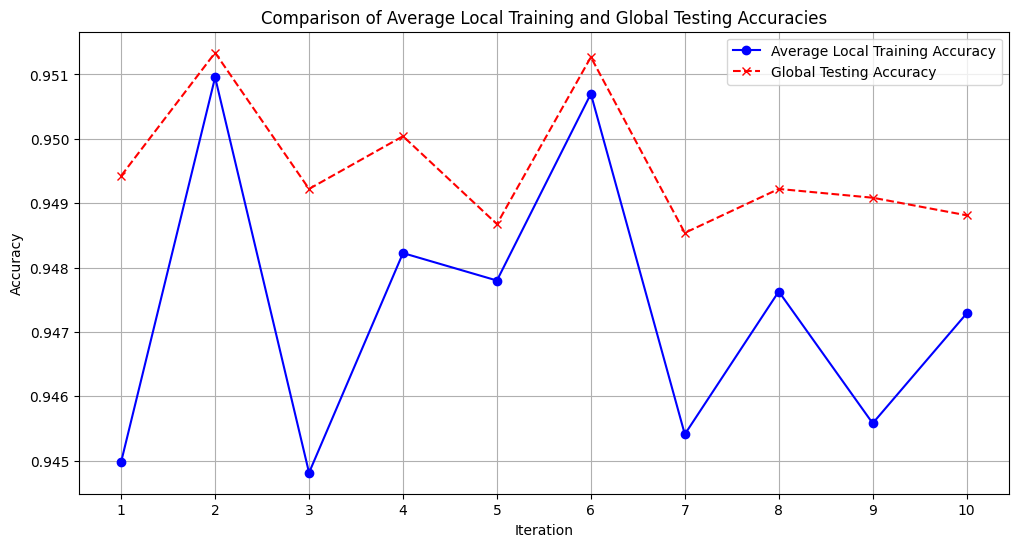

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Seed for reproducibility
np.random.seed(42)

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Perform one-hot encoding on the categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define the fixed set of features to be used by all nodes
selected_features = ['AXRASH', 'AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH', 'AXCOUGH'] \
                    + [col for col in df.columns if col.startswith(('VISCODE', 'VISCODE2', 'SITEID'))]

# Define the target variable
target = 'Phase'

# Create balanced splits
balanced_splits = [df.sample(frac=1, replace=False).reset_index(drop=True) for _ in range(num_splits)]

# Initialize placeholders for storing the accuracies across all iterations
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
all_global_accuracies = []

# Placeholder for the global model parameters
global_model_parameters = {
    'coef': np.zeros((1, len(selected_features))),
    'intercept': np.zeros(1)
}

# Function to compute the weighted average of model parameters
def weighted_average(models, weights):
    # Ensure the coefficients are in the correct shape for averaging
    coefs = np.array([model['coef'] for model in models])
    intercepts = np.array([model['intercept'] for model in models])

    # Compute weighted average for coefficients and intercepts
    avg_coef = np.average(coefs, axis=0, weights=weights)
    avg_intercept = np.average(intercepts, weights=weights)

    return avg_coef, avg_intercept


# Function to calculate weights for federated averaging based on dataset size and accuracy
def calculate_weights(sizes, accuracies):
    total_size = sum(sizes)
    total_accuracy = sum(accuracies)
    return [(size / total_size) * (accuracy / total_accuracy) for size, accuracy in zip(sizes, accuracies)]

# Function to shift data between nodes
def shift_data(balanced_splits, shift_fraction=0.25):
    shifted_splits = []
    for i, node_data in enumerate(balanced_splits):
        shift_amount = int(len(node_data) * shift_fraction)
        data_to_shift = node_data.iloc[-shift_amount:]
        next_node_data = balanced_splits[(i + 1) % num_splits]
        new_data_for_next_node = pd.concat([next_node_data.iloc[shift_amount:], data_to_shift]).reset_index(drop=True)
        shifted_splits.append(new_data_for_next_node)
    return shifted_splits

# Training and evaluation process
for iteration in range(num_iterations):
    local_accuracies = []
    local_sizes = []
    local_models = []

    # Shift data for each iteration after the first
    if iteration > 0:
        balanced_splits = shift_data(balanced_splits)

    # Train local models
    for node in range(num_splits):
        node_data = balanced_splits[node]
        X_train, X_test, y_train, y_test = train_test_split(
            node_data[selected_features], node_data[target], test_size=0.4, train_size=0.6, random_state=iteration
        )

        local_sizes.append(len(X_train))

        # Train logistic regression model
        local_model = LogisticRegression(max_iter=1000, solver='liblinear', C=0.1)
        local_model.fit(X_train, y_train)

        # Predict and calculate accuracy
        train_accuracy = local_model.score(X_train, y_train)
        test_accuracy = local_model.score(X_test, y_test)
        local_accuracies.append(test_accuracy)
        all_local_accuracies[f'Node {node+1}'].append(test_accuracy)

        # Store model updates
        local_models.append({
            'coef': local_model.coef_[0],
            'intercept': local_model.intercept_[0]
        })

    # Calculate weights based on data size and local model performance
    weights = calculate_weights(local_sizes, local_accuracies)

    # Federated  weighted averaging
    avg_coef, avg_intercept = weighted_average(local_models, weights)

    # Update global model parameters
    global_model_parameters['coef'] = avg_coef
    global_model_parameters['intercept'] = avg_intercept

    # Test global model on all nodes
    global_model = LogisticRegression(max_iter=1000, solver='liblinear')
    global_model.coef_ = np.array([avg_coef])
    global_model.intercept_ = np.array([avg_intercept])
    global_model.classes_ = np.unique(y_test)

    global_test_accuracies = []
    for node_data in balanced_splits:
        X_test = node_data[selected_features]
        y_test = node_data[target]
        global_test_accuracy = global_model.score(X_test, y_test)
        global_test_accuracies.append(global_test_accuracy)

    # Record the average global accuracy
    all_global_accuracies.append(np.mean(global_test_accuracies))

# Save the results to a CSV file
df_local_accuracies = pd.DataFrame(all_local_accuracies)
df_global_accuracies = pd.DataFrame({'Global Accuracy': all_global_accuracies})
df_combined = pd.concat([df_local_accuracies, df_global_accuracies], axis=1)
df_combined.to_csv('federated_learning_results.csv', index=False)

average_local_accuracies = [np.mean([accs[i] for accs in all_local_accuracies.values()]) for i in range(num_iterations)]
average_global_accuracies = all_global_accuracies

# Plotting both on the same graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_iterations + 1), average_local_accuracies, label='Average Local Training Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(range(1, num_iterations + 1), average_global_accuracies, label='Global Testing Accuracy', marker='x', linestyle='--', color='red')

# Adding title and labels
plt.title('Comparison of Average Local Training and Global Testing Accuracies')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_iterations + 1))  # Ensure x-axis ticks match the number of iterations

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# One-hot encoding for categorical features
categorical_features = ['VISCODE', 'VISCODE2', 'SITEID']
df = pd.get_dummies(df, columns=categorical_features)

# Define features to be used
selected_features = ['AXRASH', 'AXMUSCLE', 'AXURNFRQ', 'AXENERGY', 'AXDROWSY', 'AXDIZZY', 'AXBREATH', 'AXCOUGH'] + [col for col in df.columns if col.startswith(('VISCODE', 'VISCODE2', 'SITEID'))]

# Define the target variable
target = 'Phase'

# Number of iterations and splits
num_iterations = 10
num_splits = 6

# Placeholder for global model parameters (not directly used in F1 calculation)
global_model_parameters = {'coef': np.zeros((1, len(selected_features))), 'intercept': np.zeros(1)}

# Initialize placeholders for storing the accuracies and F1 scores across all iterations
all_local_accuracies = {f'Node {i+1}': [] for i in range(num_splits)}
all_local_f1_scores = {f'Node {i+1}': [] for i in range(num_splits)}

for iteration in range(num_iterations):
    # Shuffle and split the dataset
    df_shuffled = df.sample(frac=1, random_state=iteration * 123)
    data_splits = [df_shuffled.iloc[i * len(df_shuffled) // num_splits: (i + 1) * len(df_shuffled) // num_splits] for i in range(num_splits)]

    local_accuracies_iteration = []
    local_f1_scores_iteration = []

    for i, split_data in enumerate(data_splits):
        # Select features for training
        X_train, X_test, y_train, y_test = train_test_split(split_data[selected_features], split_data[target], test_size=0.4, random_state=iteration)

        # Train a local model
        local_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

        # Predict and evaluate
        y_pred = local_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')  # Adjust 'macro' as necessary

        # Store the accuracy and F1 score
        all_local_accuracies[f'Node {i+1}'].append(accuracy)
        all_local_f1_scores[f'Node {i+1}'].append(f1)

# Convert the accuracies and F1 scores to DataFrames
df_local_accuracies = pd.DataFrame(all_local_accuracies)
df_local_f1_scores = pd.DataFrame(all_local_f1_scores)

# Optionally, save the accuracies and F1 scores to CSV files
df_local_accuracies.to_csv('local_accuracies.csv', index_label='Iteration')
df_local_f1_scores.to_csv('local_f1_scores.csv', index_label='Iteration')

print("Local accuracies and F1 scores have been saved.")


Local accuracies and F1 scores have been saved.


In [ ]:
from sklearn.metrics import f1_score

# Load the dataset into a pandas dataframe
df = pd.read_csv('ADSXLIST_07Sep2023.csv')

# Define the number of iterations and splits
num_iterations = 10
num_splits = 6

# Lists to store accuracy and F1 score for each iteration
local_accuracy_all_iterations = []
local_f1_all_iterations = []  # Add a list for F1 scores

for iteration in range(num_iterations):
    # Shuffle the data randomly for each iteration
    df_shuffled = df.sample(frac=1, random_state=iteration * 123)
    # Initial Splitting and Data Shifting omitted for brevity

    local_accuracy_iteration = []
    local_f1_iteration = []  # Add a list for storing F1 scores for the current iteration

    for i in range(num_splits):
        split_data = data_splits[i]
        # Feature selection and preprocessing steps omitted for brevity

        # Training and testing split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=359)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')  # You can change 'macro' to another average method if needed

        local_accuracy_iteration.append(accuracy)
        local_f1_iteration.append(f1)  # Store the F1 score

    local_accuracy_all_iterations.append(local_accuracy_iteration)
    local_f1_all_iterations.append(local_f1_iteration)  # Store F1 scores for all nodes in the current iteration

# Organizing the accuracy and F1 score results into a DataFrame and saving to CSV
accuracy_results_df = pd.DataFrame(local_accuracy_all_iterations, columns=[f'Node {i+1} Accuracy' for i in range(num_splits)])
f1_results_df = pd.DataFrame(local_f1_all_iterations, columns=[f'Node {i+1} F1 Score' for i in range(num_splits)])

# Save the results to CSV files
accuracy_results_df.to_csv('model_accuracy_results.csv', index_label='Iteration')
f1_results_df.to_csv('model_f1_results.csv', index_label='Iteration')

print("Accuracy results saved to 'model_accuracy_results.csv'")
print("F1 score results saved to 'model_f1_results.csv'")


NameError: name 'X' is not defined